## <center>Face Mask Detection and Classification <center>

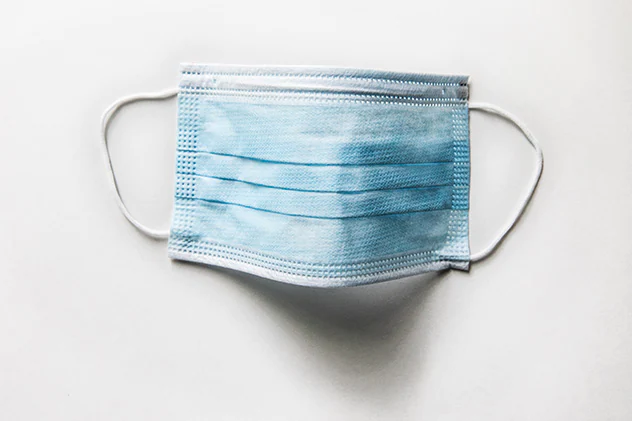

Example of a face mask picture obtained from [Mayo Clinic](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.mayoclinic.org%2Fdiseases-conditions%2Fcoronavirus%2Fin-depth%2Fcoronavirus-mask%2Fart-20485449&psig=AOvVaw3MJzTAEiW_rfc0cZ8nehkG&ust=1678895939668000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCMDai_Pk2_0CFQAAAAAdAAAAABAF)

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. It is possible to detect if people are wearing the face mask or not and this can help ensure the health is not compromised at any time.

### Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import svm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model,save_model

In [2]:
path = './Face Mask Dataset'

In [3]:
isexist = os.path.exists(path)
#checking if path exists

In [4]:
print(isexist)

True


In [5]:
#joining paths 
train_dir = os.path.join(path,'Train')
val_dir = os.path.join(path,'Validation')
test_dir = os.path.join(path,'Test')

In [6]:
print(train_dir)

./Face Mask Dataset\Train


In [7]:
#data augmentation in train data and use of  imagedatagenerator for image generation from directory
train_gen = ImageDataGenerator(rescale = 1/255, #normalization
                               horizontal_flip=True,
                               vertical_flip=True,
                               zoom_range = 0.2)
val_gen = ImageDataGenerator(rescale = 1/255)
test_gen = ImageDataGenerator(rescale = 1/255)

In [8]:
#flowing all images from directory

train_ds = train_gen.flow_from_directory(
    directory = train_dir,
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = 32,
    color_mode = 'rgb',
    shuffle = True,
    seed = 42,

)

val_ds = val_gen.flow_from_directory(
    directory = val_dir,
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = 32,
    color_mode = 'rgb',
    seed = 42,
    shuffle = True
)

test_ds = test_gen.flow_from_directory(
    directory = test_dir,
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = 32,
    color_mode = 'rgb',
    shuffle = False
)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [9]:
class_dict  = train_ds.class_indices
print(class_dict)


#zero is images with mask while 1 is images without mask

{'WithMask': 0, 'WithoutMask': 1}


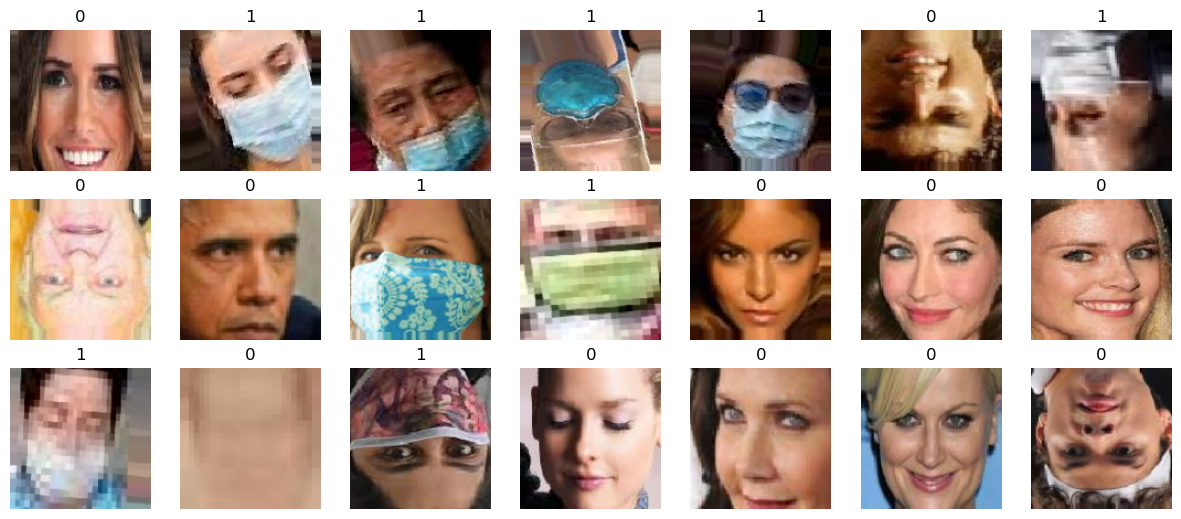

In [10]:
# data visualization

image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(15, 15))
for i in range(21):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(round(label[0]))
    plt.axis("off")

### Building the model
I am going to create a random CNN architecture and compare it with the results using an already pretrained model such as VGG16, mobilenet and resnet

In [11]:
num_classes = 2

In [12]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(256, 3, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                        

In [13]:
# dot_img_file = './model_1.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [14]:
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
# defining callback function to avoid overfit
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

In [16]:
cnn_model_history = model.fit(train_ds,validation_data = val_ds,
    steps_per_epoch=len(train_ds)//16,
    epochs=20,
    validation_steps=len(val_ds)//16,
    callbacks = [earlystopping])

Epoch 1/20
19/19 [==============================] - 15s 682ms/step - loss: 0.4614 - accuracy: 0.7961 - val_loss: 0.6605 - val_accuracy: 0.5625
Epoch 2/20
19/19 [==============================] - 11s 576ms/step - loss: 0.2625 - accuracy: 0.9030 - val_loss: 0.5757 - val_accuracy: 0.7188
Epoch 3/20
19/19 [==============================] - 10s 523ms/step - loss: 0.1956 - accuracy: 0.9243 - val_loss: 0.4789 - val_accuracy: 0.9062
Epoch 4/20
19/19 [==============================] - 10s 530ms/step - loss: 0.2384 - accuracy: 0.9013 - val_loss: 0.6601 - val_accuracy: 0.5938
Epoch 5/20
19/19 [==============================] - 10s 532ms/step - loss: 0.2366 - accuracy: 0.8997 - val_loss: 0.6288 - val_accuracy: 0.5625
Epoch 6/20
19/19 [==============================] - 10s 539ms/step - loss: 0.1966 - accuracy: 0.9260 - val_loss: 0.5334 - val_accuracy: 0.7188
Epoch 7/20
19/19 [==============================] - 14s 752ms/step - loss: 0.1457 - accuracy: 0.9457 - val_loss: 0.4470 - val_accuracy: 0.9375

# using a pretrained model to check for better accuracy

In [18]:
from keras.applications.resnet import ResNet50

In [19]:
resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in resnet.layers:
    layer.trainable = False
    
fine_model = Sequential()
fine_model.add(resnet)
fine_model.add(Flatten())
fine_model.add(Dense(2,activation='softmax'))
fine_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 23,653,250
Trainable params: 65,538
Non-trainable params: 23,587,712
_________________________________________________________________


In [20]:
fine_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [21]:
fine_model_history = fine_model.fit(train_ds,validation_data = val_ds,
    steps_per_epoch=len(train_ds)//16,
    epochs=20,
    validation_steps=len(val_ds)//16,
    callbacks = [earlystopping])

Epoch 1/20
19/19 [==============================] - 36s 2s/step - loss: 0.7066 - accuracy: 0.5674 - val_loss: 0.7140 - val_accuracy: 0.4375
Epoch 2/20
19/19 [==============================] - 28s 1s/step - loss: 0.6390 - accuracy: 0.6332 - val_loss: 0.6305 - val_accuracy: 0.7188
Epoch 3/20
19/19 [==============================] - 26s 1s/step - loss: 0.6405 - accuracy: 0.6398 - val_loss: 0.7131 - val_accuracy: 0.5312
Epoch 4/20
19/19 [==============================] - 26s 1s/step - loss: 0.6188 - accuracy: 0.6645 - val_loss: 0.5932 - val_accuracy: 0.6875
Epoch 5/20
19/19 [==============================] - 26s 1s/step - loss: 0.6160 - accuracy: 0.6595 - val_loss: 0.5825 - val_accuracy: 0.6562
Epoch 6/20
19/19 [==============================] - 31s 2s/step - loss: 0.6354 - accuracy: 0.6316 - val_loss: 0.7104 - val_accuracy: 0.5625
Epoch 7/20
19/19 [==============================] - 29s 1s/step - loss: 0.6500 - accuracy: 0.6431 - val_loss: 0.5200 - val_accuracy: 0.7500
Epoch 8/20
19/19 [==

In [22]:
fine_model.evaluate(val_ds)[1]

25/25 [==============================] - 46s 2s/step - loss: 0.5208 - accuracy: 0.7475


0.7475000023841858

The accuracy for the pretrained model on the validation set is about 75%

In [23]:
model.evaluate(val_ds)

25/25 [==============================] - 4s 165ms/step - loss: 0.1391 - accuracy: 0.9825


[0.13905540108680725, 0.9825000166893005]

Evaluation with the cnn architecture created earlier, I got an accuracy of about 98%. 

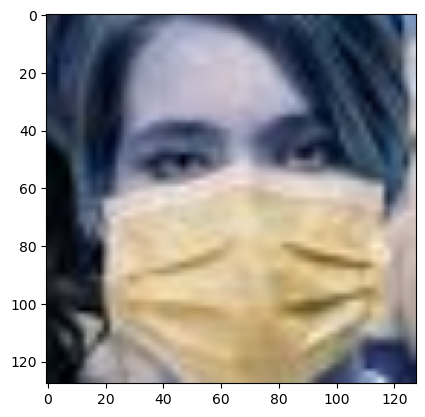

In [24]:
#checking an image from the test set

sample_mask_img = cv2.imread('./Face Mask Dataset/Test/WithMask/1389.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [25]:
model.predict(sample_mask_img)

1/1 [==============================] - 0s 247ms/step


array([[0.70557964, 0.29442036]], dtype=float32)

Excellent, I got a good output. The model accurately predicted that the person was wearing a face mask

In [26]:
fine_model.predict(sample_mask_img)

1/1 [==============================] - 2s 2s/step


array([[0.67385036, 0.32614964]], dtype=float32)

The fine tuned model also gave a fair result of 67% for 'with mask'. We could improve this by runnng for more epochs

In [27]:
# model.save('model.h5')
# model.save('finemodel.h5')

In [28]:
def plot_history(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
#     plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

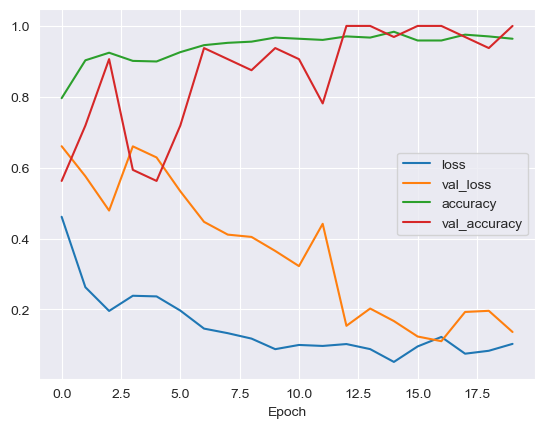

In [42]:
plot_history(cnn_model_history)

# using another pretrained model mobile net

I love mobile net because its simple yet it is capable of giving great results.

In [30]:
from keras.applications.mobilenet import MobileNet

In [31]:
base_model = MobileNet(weights = 'imagenet', include_top = False, input_shape =(128,128,3))


In [32]:
for layer in base_model.layers:
    layer.trainable = False

In [33]:
m_model = Sequential()
m_model.add(base_model)
m_model.add(Flatten())
m_model.add(Dense(32, activation = 'relu'))
m_model.add(Dense(num_classes,activation = 'softmax'))

In [34]:
m_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                524320    
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,753,250
Trainable params: 524,386
Non-trainable params: 3,228,864
_________________________________________________________________


In [35]:
m_model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics ="accuracy")

In [36]:
mobilenet_model = m_model.fit(train_ds,
    validation_data = val_ds,
    steps_per_epoch=len(train_ds)//16,
    epochs=20,
    validation_steps=len(val_ds)//16,
    callbacks = [earlystopping])

Epoch 1/20
19/19 [==============================] - 13s 548ms/step - loss: 0.3067 - accuracy: 0.9178 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 2/20
19/19 [==============================] - 9s 494ms/step - loss: 0.1011 - accuracy: 0.9868 - val_loss: 0.1232 - val_accuracy: 0.9688
Epoch 3/20
19/19 [==============================] - 10s 504ms/step - loss: 0.0680 - accuracy: 0.9814 - val_loss: 0.0901 - val_accuracy: 0.9688
Epoch 4/20
19/19 [==============================] - 10s 533ms/step - loss: 0.0646 - accuracy: 0.9770 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 5/20
19/19 [==============================] - 11s 556ms/step - loss: 0.0162 - accuracy: 0.9934 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/20
19/19 [==============================] - 10s 513ms/step - loss: 0.0271 - accuracy: 0.9918 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/20
19/19 [==============================] - 10s 523ms/step - loss: 0.0114 - accuracy: 0.9951 - val_loss: 1.2036e-05 - val_accuracy: 1.0

In [37]:
model.evaluate(val_ds)[1]

25/25 [==============================] - 4s 165ms/step - loss: 0.1391 - accuracy: 0.9825


0.9825000166893005

The mobile net gave an excellent result of about 98% accuracy

### Confusion Matrix

In [38]:
sns.set_style('darkgrid')
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
#     clr = classification_report(y_true, y_pred, target_names=classes)
#     print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<4:
        fig_width=4
        fig_height=4
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()



31/31 [==============================] - 15s 441ms/step


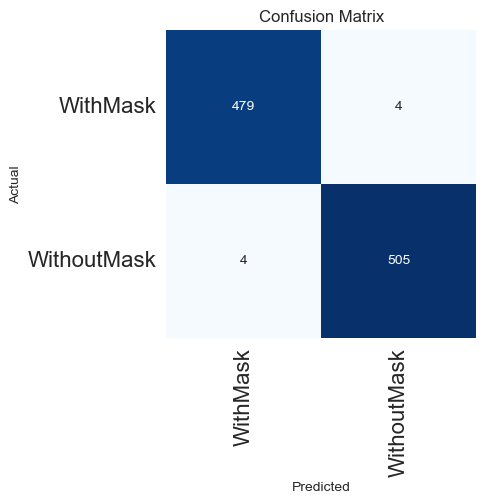

In [39]:
cm_cr(test_ds, m_model)

After visualizing, Its obvious that this the model was able to generalize properly.

31/31 [==============================] - 50s 2s/step


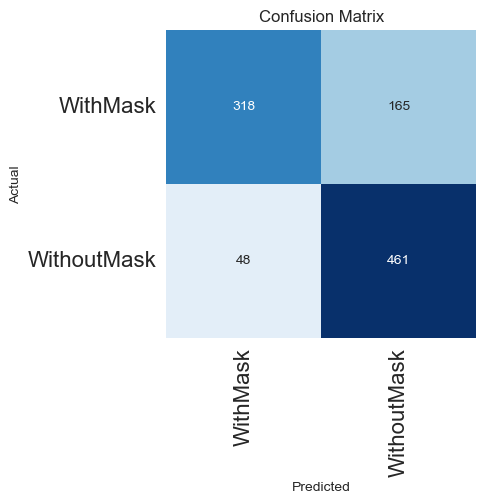

In [40]:
cm_cr(test_ds, fine_model)

There are still some misclassifications so this model can be improved upon by running for more epochs

## Checking results for external images

Let's use ex-president Donald Trump pictures to determine if the mobile net model is able to give accurate results

In [43]:
image1 = plt.imread(r"C:\Users\DELL\Downloads\trumpmask.jpg")
image2 = plt.imread(r"C:\Users\DELL\Downloads\trump.jpg")


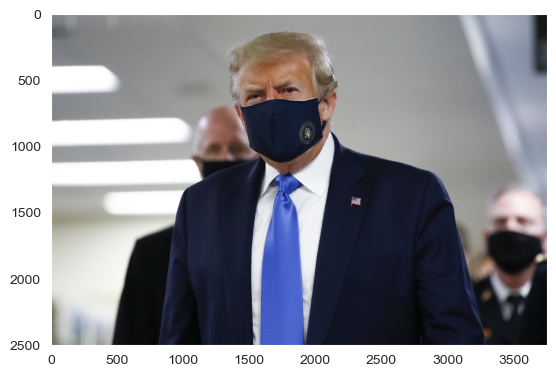

In [54]:
plt.imshow(image1)
plt.grid();

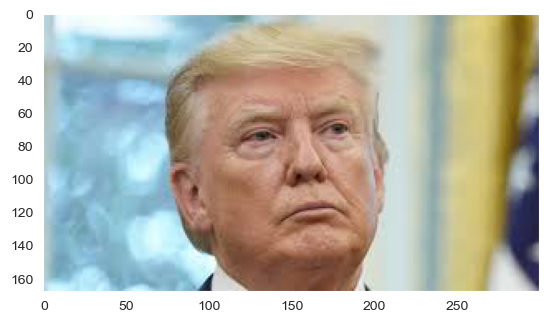

In [55]:
plt.imshow(image2)
plt.grid();

In [46]:
def image_processor(image):
    image = cv2.resize(image, (128,128))
    image = np.reshape(image,[1,128,128,3])
    image = image/255.0
    return image

In [47]:
processed_image1 = image_processor(image1)

In [48]:
m_model.predict(processed_image1)

1/1 [==============================] - 1s 712ms/step


array([[9.9991763e-01, 8.2368715e-05]], dtype=float32)

The model gave an excellent result showing Trump wore a face mask in image 1

In [49]:
processed_image2 = image_processor(image2)

In [50]:
m_model.predict(processed_image2)

1/1 [==============================] - 0s 43ms/step


array([[4.5698298e-06, 9.9999547e-01]], dtype=float32)

In [ ]:
The model also gave an excellent result showing Trump did not put on a face mask in image 2

In [60]:
m_model.save('./mobileNetBestModel')

INFO:tensorflow:Assets written to: ./mobileNetBestModel\assets


INFO:tensorflow:Assets written to: ./mobileNetBestModel\assets


In [59]:
#loading model..........
#model =  keras.models.load_model('./mobileNetBestModel')